# Structure MCMC with DEO parallel tempering scheme (and dynamic tuning of temperatures)
### $MC^3$, $REV$ and $MBR$ moves implemented
In this notebook you can find the functions for sampling DAGs using a simple structure MCMC or using a structure MCMC with a parallel tempering scheme implemented (DEO, SEO and single swap schemes).

Two structure priors implemented: uniform and sparse.


A practical example of sampling DAGs using DEO Structure MCMC can be found at the end of the notebook.

In [2]:
import re
import numpy as np
import random
import scipy
import math
import matplotlib.pyplot as plt
import splines   
from scipy.special import logsumexp
from math import comb

### Loading the score file for the data  from .jkl format (BDeu or BGe score)

In [4]:

def cache_f (path,max_parents,n_nodes):

    with open(path,'r') as file:
        filedata = file.readlines()

    n_parents_set=[]
    cache ={}
    
    t=1
    vertices=[]
    for i in range (n_nodes):
        line = filedata[t]
        vertices.append(int(re.findall(r'\d+', line)[0]))
        t+=int(re.findall(r'\d+', line)[1])+1

    t=1
    for i in vertices :
        line = filedata[t]
        now_n_parents_set =int(re.findall(r'\d+', line)[1])

        n_parents_set.append(now_n_parents_set)
        now_dict= {}

        for j in range(now_n_parents_set):
            now_parents=()
            for k in range (len(re.findall(r'\d+', filedata[t+j+1]))-3):

                now_parents= now_parents + (int(re.findall(r'\d+', filedata[t+j+1])[k+3]),)

            now_parents=tuple(sorted(now_parents))

            now_dict[now_parents]=float(filedata[t+j+1].split(' ')[0])
        cache[i]=now_dict
        t=t+now_n_parents_set+1
    return cache



### Generic functions 

In [6]:


def is_dag(adjacency_matrix):
    num_nodes = adjacency_matrix.shape[0]

    colors = np.zeros(num_nodes, dtype=int)

    def dfs(node):
        nonlocal colors

        colors[node] = 1  

        for neighbor in np.where(adjacency_matrix[node] == 1)[0]:
            if colors[neighbor] == 1:
                return False  
            elif colors[neighbor] == 0:
                if not dfs(neighbor):
                    return False

        colors[node] = 2 
        return True

    for node in range(num_nodes):
        if colors[node] == 0:
            if not dfs(node):
                return False  

    return True 

def generate_random_dag_adjacency_matrix(num_nodes,max_parents):
    if num_nodes <= 0:
        raise ValueError("Number of nodes must be greater than 0.")

    nodes = np.random.permutation(num_nodes)

    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    for i in range(num_nodes - 1):
        num_edges = np.random.randint(1, num_nodes - i)

        target_nodes = np.random.choice(nodes[i+1:], size=num_edges, replace=False)

        adjacency_matrix[nodes[i], target_nodes] = 1

    new_dag= np.zeros((num_nodes,num_nodes),dtype=np.int8)
    for i in range (num_nodes):
        a=list(np.where(adjacency_matrix[:,i]==1)[0])
        b=random.randint(0,max_parents)
        c=random.sample(sorted(a), min(len(a),b))
        for j in c:
            new_dag[j,i]=1
    return new_dag


def score(dag):
    prior=1
    loglik=0

    for i in range(n_variables):
        prior= prior*(1/math.comb((n_variables-1),int(np.sum(dag[:,i]))))
        loglik+= cache[i][tuple(np.where(dag[:,i]==1)[0])]
    return loglik+ np.log(prior)



def bisection_at_x (f,a,b,x,max_iter=100,tol=1e-6):
    for i in range (max_iter):
        c = (a + b) / 2
        if ((f(c) == x) or ((b - a) / 2 < tol)):
            return(c)
        if (f(c)< x):
            a = c
        else:
            b = c
    return (c)

### Single $MC^3$ move (for structure MCMC without PT)

In [8]:


def mcmcmc (dag_now_p, loglik_now_p, prior_now_p, score_now_p,cache, beta=1):
    global score_now, dag_now, loglik_now, prior_now, max_parents,uniform

    if beta==None:
        beta=1
    
    dag0=np.copy(dag_now_p)
    
    condition=False
    n_variables=len(dag_now_p[0])
    while(condition==False):
        u=random.randint(0, n_variables-1)
        v=list(range(n_variables))
        v.remove(u)
        v=random.choice(v)
        dag1=np.copy(dag_now_p)
        if (dag_now_p[u,v]==1) :
            dag1[u,v]=0
        elif (dag_now_p[v,u]==1):
            dag1[u,v]=1
            dag1[v,u]=0
            if (np.sum(dag1[:,v])>max_parents):
                dag1[u,v]=0
                dag1[v,u]=1
            elif (is_dag(dag1)==False):
                dag1[u,v]=0
                dag1[v,u]=1
        elif (dag_now_p[u,v]==0 and dag_now_p[v,u]==0):
            dag1[u,v]=1
            if np.sum(dag1[:,v])>max_parents:
                dag1[u,v]=0
            elif (is_dag(dag1)==False):
                dag1[u,v]=0
        condition=True

    prior_1=1
    loglik_1=0
    prior_0=np.copy(prior_now_p)
    loglik_0=np.copy(loglik_now_p)


    for i in range(n_variables):
        if uniform==False:
            prior_1= prior_1*(1/comb((n_variables-1),np.sum(dag1[:,i])))
        loglik_1+= cache[i][tuple(np.where(dag1[:,i]==1)[0])]

    prior_1=np.log(prior_1)

    
    alpha= min(beta*(loglik_1-loglik_0)+prior_1-prior_0,0)

    rand=random.random()



    if rand < np.exp(alpha):


        dag_now=np.copy(dag1)
        prior_now = np.copy(prior_1)
        loglik_now= np.copy(loglik_1)
        score_now= np.copy(prior_now+loglik_now)



### Single $MC^3$ move (for PT Structure MCMC)

In [10]:




def pt_mcmcmc (dags_now_p, loglik_now_p, prior_now_p, beta,cache):
    global dags_now, loglik_now, prior_now, iterator, n_variables, max_parents, n_chains,uniform

    condition=False
    while(condition==False):
        u=random.randint(0, n_variables-1)
        v=list(range(n_variables))
        v.remove(u)
        v=random.choice(v)
        dag1=np.copy(dags_now_p[:,:,iterator])
        if (dags_now_p[u,v,iterator]==1) :
            dag1[u,v]=0

        elif (dags_now_p[v,u,iterator]==1):
            dag1[u,v]=1
            dag1[v,u]=0
            if  (np.sum(dag1[:,v])>max_parents):
                dag1[u,v]=0
                dag1[v,u]=1
      
            elif (is_dag(dag1)==False):
                dag1[u,v]=0
                dag1[v,u]=1
        elif (dags_now_p[u,v,iterator]==0 and dags_now_p[v,u,iterator]==0):
            dag1[u,v]=1
            if  np.sum(dag1[:,v])>max_parents:
                dag1[u,v]=0

            elif (is_dag(dag1)==False):
                dag1[u,v]=0
        condition=True

    dag0=np.copy(dags_now_p[:,:,iterator])
    prior_1=1
    loglik_1=0

    prior_0=np.copy(prior_now_p[iterator])
    loglik_0=np.copy(loglik_now_p[iterator])

    for i in range(n_variables):
        if uniform==False:
            prior_1= prior_1*(1/math.comb((n_variables-1),int(np.sum(dag1[:,i]))))
        loglik_1+= cache[i][tuple(np.where(dag1[:,i]==1)[0])]

    prior_1=np.log(prior_1)

    alpha= min(beta*(loglik_1-loglik_0)+prior_1-prior_0,0)

    rand=random.random()

    if rand < np.exp(alpha):


        dags_now[:,:,iterator]=np.copy(dag1)
        prior_now[iterator] = np.copy(prior_1)
        loglik_now[iterator]= np.copy(loglik_1)
    

### Single $REV$ move (for Structure MCMC without PT)

In [12]:
from scipy.special import logsumexp

def rev (dag_now_p, loglik_now_p, prior_now_p, score_now_p, cache, beta=1):
    global score_now, dag_now, loglik_now, prior_now, iterator, n_variables, max_parents, n_chains, steps, rev_post, rev_tot,rand_steps,uniform

    condition= False
    dag1=np.copy(dag_now_p)
    dag0=np.copy(dag_now_p)


    if np.sum(dag0)==0:
        return None

    while(condition==False):
        ind=np.where(dag0==1)
        indexes=[]
 
        for i in range (len(ind[0])):
            indexes.append([ind[0][i],ind[1][i]])
        
        edge= random.sample(indexes,1)[0]
        u=edge[0]
        v=edge[1]
  
        pi_j=np.where(dag0[:,v])

        dag1[:,u]=np.zeros(n_variables)
        dag1[:,v]=np.zeros(n_variables)


        d_u=np.where(dag1[u,:]==1)[0]
        dd_u=list(np.copy(d_u))
     
        visited=[]
        while len(dd_u)!=0:
            child=dd_u.pop()
           
            if child not in visited:
                visited.append(child)
                for nephew in np.where(dag1[child,:]==1)[0]:
            
                    d_u=np.append(d_u,nephew)
                    dd_u.append(nephew)
     
                dd_u=list(set(dd_u))
    
        d_u=set(d_u)
 

        d_v=np.where(dag1[v,:]==1)[0]
        dd_v=list(np.copy(d_v))
 
        visited=[]
        while len(dd_v)!=0:
            child=dd_v.pop()
         
            if child not in visited:
                visited.append(child)
                for nephew in np.where(dag1[child,:]==1)[0]:
      
                    d_v=np.append(d_v,nephew)
                    dd_v.append(nephew)

                dd_v=list(set(dd_v))

        d_v=set(d_v)


        pi_i_set=[item for item in cache[u] if v in item]

        for i in d_u:
            pi_i_set=[item for item in pi_i_set if i not in item]
            

        z_star_i_dot_j=[]
        for i in pi_i_set:
            if uniform==False:
                z_star_i_dot_j.append(cache[u][i]+np.log(1/math.comb((n_variables-1),int(len(i)))))
            else:
                z_star_i_dot_j.append(cache[u][i])

        Z=np.copy(z_star_i_dot_j)
        z_star_i_dot_j=logsumexp(z_star_i_dot_j)

        
        
        log_probs = Z
        num_categories = len(Z)
        gumbels = np.random.gumbel(size=num_categories)
        sample = np.argmax(log_probs + gumbels)
        pi_i_tilde=pi_i_set[sample]

        
        dag_cross=np.copy(dag1)
        for i in pi_i_tilde:
            dag_cross[i,u]=1


        d_v_plus=np.where(dag_cross[v,:]==1)[0]
        dd_v=list(np.copy(d_v_plus))

        visited=[]
        while len(dd_v)!=0:
            child=dd_v.pop()

            if child not in visited:
                visited.append(child)
                for nephew in np.where(dag_cross[child,:]==1)[0]:

                    d_v_plus=np.append(d_v_plus,nephew)
                    dd_v.append(nephew)

                dd_v=list(set(dd_v))

        d_v_plus=set(d_v_plus)


        pi_j_cross_set=[item for item in cache[v]]
        for i in d_v_plus:
            pi_j_cross_set=[item for item in pi_j_cross_set if i not in item]
            

        
        z_j_cross=[]
        for i in pi_j_cross_set:
            if uniform==False:
                z_j_cross.append(cache[v][i]+np.log(1/math.comb((n_variables-1),int(len(i)))))
            else:
                z_j_cross.append(cache[v][i])
                
        Z=np.copy(z_j_cross)
        z_j_cross=logsumexp(z_j_cross)
        
        log_probs = Z
        num_categories = len(Z)
        gumbels = np.random.gumbel(size=num_categories)
        sample = np.argmax(log_probs + gumbels)
        pi_j_tilde=pi_j_cross_set[sample]

        
        dag_tilde=np.copy(dag_cross)
        
        for i in pi_j_tilde:
            dag_tilde[i,v]=1
            

            
        ''' backwards'''  
            
        pi_j_set_2=[item for item in cache[v] if u in item]
        for i in d_v:
            pi_j_set_2=[item for item in pi_j_set_2 if i not in item]   
            

        
        z_star_j_dot_i=[]
        for i in pi_j_set_2:
            if uniform==False:
                z_star_j_dot_i.append(cache[v][i]+np.log(1/math.comb((n_variables-1),int(len(i)))))
            else:
                z_star_j_dot_i.append(cache[v][i])
                
        z_star_j_dot_i=logsumexp(z_star_j_dot_i)
        
        dag_tilde_cross=np.copy(dag1)
        for i in pi_j:
            dag_tilde_cross[i,v]=1

            
        d_u_plus=np.where(dag_tilde_cross[u,:]==1)[0]
        dd_u=list(np.copy(d_u_plus))

        visited=[]
        while len(dd_u)!=0:
            child=dd_u.pop()

            if child not in visited:
                visited.append(child)
                for nephew in np.where(dag_tilde_cross[child,:]==1)[0]:
 
                    d_u_plus=np.append(d_u_plus,nephew)
                    dd_u.append(nephew)

                dd_u=list(set(dd_u))
 
        d_u_plus=set(d_u_plus)
 
        
        
        pi_i_cross_set=[item for item in cache[u]]
        for i in d_u_plus:
            pi_i_cross_set=[item for item in pi_i_cross_set if i not in item]
 
        
        z_i_cross=[]
        for i in pi_i_cross_set:
            if uniform==False:
                z_i_cross.append(cache[u][i]+np.log(1/math.comb((n_variables-1),int(len(i)))))
            else:
                z_i_cross.append(cache[u][i])
        z_i_cross=logsumexp(z_i_cross)
        

        condition= True

    prior_1=1
    loglik_1=0



    for i in range(n_variables):
        if uniform==False:
            prior_1= prior_1*(1/math.comb((n_variables-1),int(np.sum(dag_tilde[:,i]))))
        loglik_1+= cache[i][tuple(np.where(dag_tilde[:,i]==1)[0])]

    alpha=min(0,np.log(np.sum(dag0))-np.log(np.sum(dag_tilde))+z_star_i_dot_j+z_j_cross-z_star_j_dot_i-z_i_cross)

    rand=random.random()

    if rand < np.exp(alpha):

        dag_now=np.copy(dag_tilde)
        prior_now = np.copy(np.log(prior_1))
        loglik_now= np.copy(loglik_1)
        score_now=np.copy(loglik_now+prior_now)


### Single $REV$ move (for PT structure MCMC)

In [14]:
def pt_rev (dags_now_p, loglik_now_p, prior_now_p, beta, cache):
    global  dags_now, loglik_now, prior_now, iterator, n_variables, max_parents, n_chains,uniform

    condition= False
    dag1=np.copy(dags_now_p[:,:,iterator])
    dag0=np.copy(dags_now_p[:,:,iterator])


    if np.sum(dag0)==0:
        return None

    while(condition==False):
        ind=np.where(dag0==1)
        indexes=[]
    
        for i in range (len(ind[0])):
            indexes.append([ind[0][i],ind[1][i]])
        

        edge= random.sample(indexes,1)[0]
        u=edge[0]
        v=edge[1]
  

        pi_j=np.where(dag0[:,v])

        dag1[:,u]=np.zeros(n_variables)
        dag1[:,v]=np.zeros(n_variables)
  
        d_u=np.where(dag1[u,:]==1)[0]
        dd_u=list(np.copy(d_u))
    
        visited=[]
        while len(dd_u)!=0:
            child=dd_u.pop()
      
            if child not in visited:
                visited.append(child)
                for nephew in np.where(dag1[child,:]==1)[0]:
                  
                    d_u=np.append(d_u,nephew)
                    dd_u.append(nephew)
     
                dd_u=list(set(dd_u))
      
        d_u=set(d_u)
  

        d_v=np.where(dag1[v,:]==1)[0]
        dd_v=list(np.copy(d_v))
  
        visited=[]
        while len(dd_v)!=0:
            child=dd_v.pop()
       
            if child not in visited:
                visited.append(child)
                for nephew in np.where(dag1[child,:]==1)[0]:
           
                    d_v=np.append(d_v,nephew)
                    dd_v.append(nephew)
      
                dd_v=list(set(dd_v))

        d_v=set(d_v)


        pi_i_set=[item for item in cache[u] if v in item]

        for i in d_u:
            pi_i_set=[item for item in pi_i_set if i not in item]
    
        z_star_i_dot_j=[]
        for i in pi_i_set:
            if uniform==False:
                z_star_i_dot_j.append(cache[u][i]*beta+np.log(1/math.comb((n_variables-1),int(len(i)))))
            else:
                z_star_i_dot_j.append(cache[u][i]*beta)

        Z=np.copy(z_star_i_dot_j)
        z_star_i_dot_j=logsumexp(z_star_i_dot_j)
 
        
        
        log_probs = Z
        num_categories = len(Z)
        gumbels = np.random.gumbel(size=num_categories)
        sample = np.argmax(log_probs + gumbels)
        pi_i_tilde=pi_i_set[sample]

        dag_cross=np.copy(dag1)
        for i in pi_i_tilde:
            dag_cross[i,u]=1


        d_v_plus=np.where(dag_cross[v,:]==1)[0]
        dd_v=list(np.copy(d_v_plus))

        visited=[]
        while len(dd_v)!=0:
            child=dd_v.pop()

            if child not in visited:
                visited.append(child)
                for nephew in np.where(dag_cross[child,:]==1)[0]:

                    d_v_plus=np.append(d_v_plus,nephew)
                    dd_v.append(nephew)

                dd_v=list(set(dd_v))

        d_v_plus=set(d_v_plus)


        pi_j_cross_set=[item for item in cache[v]]
        for i in d_v_plus:
            pi_j_cross_set=[item for item in pi_j_cross_set if i not in item]
            

        z_j_cross=[]
        for i in pi_j_cross_set:
            if uniform==False:
                z_j_cross.append(cache[v][i]*beta+np.log(1/math.comb((n_variables-1),int(len(i)))))
            else:
                z_j_cross.append(cache[v][i]*beta)
        Z=np.copy(z_j_cross)
        z_j_cross=logsumexp(z_j_cross)
        
        log_probs = Z
        num_categories = len(Z)
        gumbels = np.random.gumbel(size=num_categories)
        sample = np.argmax(log_probs + gumbels)
        pi_j_tilde=pi_j_cross_set[sample]

        dag_tilde=np.copy(dag_cross)
        
        for i in pi_j_tilde:
            dag_tilde[i,v]=1
            

        ''' backwards'''  
            
        pi_j_set_2=[item for item in cache[v] if u in item]
        for i in d_v:
            pi_j_set_2=[item for item in pi_j_set_2 if i not in item]   

        
        z_star_j_dot_i=[]
        for i in pi_j_set_2:
            if uniform==False:
                z_star_j_dot_i.append(cache[v][i]*beta+np.log(1/math.comb((n_variables-1),int(len(i)))))
            else:
                z_star_j_dot_i.append(cache[v][i]*beta)
        z_star_j_dot_i=logsumexp(z_star_j_dot_i)
        
        dag_tilde_cross=np.copy(dag1)
        for i in pi_j:
            dag_tilde_cross[i,v]=1

            
        d_u_plus=np.where(dag_tilde_cross[u,:]==1)[0]
        dd_u=list(np.copy(d_u_plus))

        visited=[]
        while len(dd_u)!=0:
            child=dd_u.pop()

            if child not in visited:
                visited.append(child)
                for nephew in np.where(dag_tilde_cross[child,:]==1)[0]:

                    d_u_plus=np.append(d_u_plus,nephew)
                    dd_u.append(nephew)

                dd_u=list(set(dd_u))

        d_u_plus=set(d_u_plus)

        
        
        pi_i_cross_set=[item for item in cache[u]]
        for i in d_u_plus:
            pi_i_cross_set=[item for item in pi_i_cross_set if i not in item]

        
        z_i_cross=[]
        for i in pi_i_cross_set:
            if uniform==False:
                z_i_cross.append(cache[u][i]*beta+np.log(1/math.comb((n_variables-1),int(len(i)))))
            else:
                z_i_cross.append(cache[u][i]*beta)
        z_i_cross=logsumexp(z_i_cross)
        

        condition= True

    alpha=min(0,np.log(np.sum(dag0))-np.log(np.sum(dag_tilde))+z_star_i_dot_j+z_j_cross-z_star_j_dot_i-z_i_cross)

    rand=random.random()

    if rand < np.exp(alpha):

        prior_1=1
        loglik_1=0


        for i in range(n_variables):
            if uniform==False:
                prior_1= prior_1*(1/math.comb((n_variables-1),int(np.sum(dag_tilde[:,i]))))
            loglik_1+= cache[i][tuple(np.where(dag_tilde[:,i]==1)[0])]
        
        dags_now[:,:,iterator]=np.copy(dag_tilde)
        prior_now[iterator]= np.copy(np.log(prior_1))
        loglik_now[iterator]= np.copy(loglik_1)


### Single $MBR$ move (for structure MCMC without PT)

In [16]:
def mbr (dag_now_p, loglik_now_p, prior_now_p, score_now_p, cache, beta=1):
    global score_now, dag_now, loglik_now, prior_now, iterator, n_variables, max_parents, n_chains, steps, rev_post, rev_tot,rand_steps,uniform

    condition= False
    dag1=np.copy(dag_now_p)
    dag0=np.copy(dag_now_p)

    if np.sum(dag0)==0:
        return None

    while(condition==False):
        
        u=random.randint(0,n_variables-1)
 
        
        pi_i=np.where(dag0[:,u]==1)[0]

        
        dag1[:,u]=np.zeros(n_variables)
        
        c_u=np.where(dag1[u,:]==1)[0]        
        for i in c_u:
            dag1[:,i]=np.zeros(n_variables)
            dag1[u,i]=1
        

        d_u=np.where(dag1[u,:]==1)[0]
        dd_u=list(np.copy(d_u))

        visited=[]
        while len(dd_u)!=0:
            child=dd_u.pop()

            if child not in visited:
                visited.append(child)
                for nephew in np.where(dag1[child,:]==1)[0]:

                    d_u=np.append(d_u,nephew)
                    dd_u.append(nephew)

                dd_u=list(set(dd_u))

        d_u=set(d_u)

        pi_i_set2=[item for item in cache[u]]

        for i in d_u:
            pi_i_set2=[item for item in pi_i_set2 if i not in item]

        pi_i_set=pi_i_set2.copy()

        for i in pi_i:
            pi_i_set=[item for item in pi_i_set if i not in item]

        
        z_star_i_dot_j=[]
        for i in pi_i_set:

            if uniform==False:
                z_star_i_dot_j.append(cache[u][i]+np.log(1/math.comb((n_variables-1),int(len(i)))))
            else:
                z_star_i_dot_j.append(cache[u][i])

        Z=np.copy(z_star_i_dot_j)

        z_star_i_dot_j=logsumexp(z_star_i_dot_j)

        
        log_probs = Z
        num_categories = len(Z)
        gumbels = np.random.gumbel(size=num_categories)

        sample = np.argmax(log_probs + gumbels)
        pi_i_tilde=pi_i_set[sample]
        

        dag_cross=np.copy(dag1)
        for i in pi_i_tilde:
            dag_cross[i,u]=1

        
        ''' until here the new parents set of u is sampled'''
        z_c=0
        c_u=list(c_u)

        random.shuffle(c_u)
        c_u=tuple(c_u)

        for v in c_u:

            d_v_plus=np.where(dag_cross[v,:]==1)[0]
            dd_v=list(np.copy(d_v_plus))

            visited=[]
            while len(dd_v)!=0:
                child=dd_v.pop()

                if child not in visited:
                    visited.append(child)
                    for nephew in np.where(dag_cross[child,:]==1)[0]:

                        d_v_plus=np.append(d_v_plus,nephew)
                        dd_v.append(nephew)

                    dd_v=list(set(dd_v))

            d_v_plus=set(d_v_plus)


            pi_j_cross_set=[item for item in cache[v] if u in item]
            for i in d_v_plus:
                pi_j_cross_set=[item for item in pi_j_cross_set if i not in item]
                

            
            z_j_cross=[]
            for i in pi_j_cross_set:
                if uniform==False:
                    z_j_cross.append(cache[v][i]+np.log(1/math.comb((n_variables-1),int(len(i)))))
                else:
                    z_j_cross.append(cache[v][i])
                    
            Z=np.copy(z_j_cross)
            z_j_cross=logsumexp(z_j_cross)
            z_c+=z_j_cross

            
            
            log_probs = Z
            num_categories = len(Z)
            gumbels = np.random.gumbel(size=num_categories)
            sample = np.argmax(log_probs + gumbels)
            pi_j_tilde=pi_j_cross_set[sample]

        
            for i in pi_j_tilde:
                dag_cross[i,v]=1

        ''' backwards'''  
        
        dag_tilde=np.copy(dag_cross)
        
        dag_tilde[:,u]=np.zeros(n_variables)
        
        c_u_b=np.where(dag_tilde[u,:]==1)[0]        
        for i in c_u_b:
            dag_tilde[:,i]=np.zeros(n_variables)
            dag_tilde[u,i]=1

        for i in pi_i_tilde:
            pi_i_set2=[item for item in pi_i_set2 if i not in item]   

        
        z_star_j_dot_i=[]
        for i in pi_i_set2:
            if uniform==False:
                z_star_j_dot_i.append(cache[u][i]+np.log(1/math.comb((n_variables-1),int(len(i)))))
            else:
                z_star_j_dot_i.append(cache[u][i])
                
        z_star_j_dot_i=logsumexp(z_star_j_dot_i)
        
        for i in pi_i:
            dag_tilde[i,u]=1
  
        
        
        
        z_c_b=0
        c_u_b=list(c_u_b)

        random.shuffle(c_u_b)
        c_u_b=tuple(c_u_b)
        for v in c_u_b:
            d_v_plus=np.where(dag_tilde[v,:]==1)[0]
            dd_v=list(np.copy(d_v_plus))

            visited=[]
            while len(dd_v)!=0:
                child=dd_v.pop()
  
                if child not in visited:
                    visited.append(child)
                    for nephew in np.where(dag_tilde[child,:]==1)[0]:
          
                        d_v_plus=np.append(d_v_plus,nephew)
                        dd_v.append(nephew)
        
                    dd_v=list(set(dd_v))
    
            d_v_plus=set(d_v_plus)

            pi_j_cross_set=[item for item in cache[v] if u in item]
            for i in d_v_plus:
                pi_j_cross_set=[item for item in pi_j_cross_set if i not in item]

            
            z_j_cross=[]
            for i in pi_j_cross_set:
                if uniform==False:
                    z_j_cross.append(cache[v][i]+np.log(1/math.comb((n_variables-1),int(len(i)))))
                else:
                    z_j_cross.append(cache[v][i])
                    
            Z=np.copy(z_j_cross)
            z_j_cross=logsumexp(z_j_cross)
            z_c_b+=np.copy(z_j_cross)

            dag_tilde[:,v]=np.copy(dag0[:,v])
    

        condition= True

    prior_1=1
    loglik_1=0



    for i in range(n_variables):
        if uniform==False:
            prior_1= prior_1*(1/math.comb((n_variables-1),int(np.sum(dag_cross[:,i]))))
        loglik_1+= cache[i][tuple(np.where(dag_cross[:,i]==1)[0])]

    alpha=min(0,z_star_i_dot_j+z_c-z_star_j_dot_i-z_c_b)

    rand=random.random()

    if rand < np.exp(alpha):

        dag_now=np.copy(dag_cross)
        prior_now = np.copy(np.log(prior_1))
        loglik_now= np.copy(loglik_1)
        score_now=np.copy(loglik_now+prior_now)


### Single $MBR$ move (for PT structure MCMC)

In [18]:
def pt_mbr (dags_now_p, loglik_now_p, prior_now_p, beta, cache):
    global  dags_now, loglik_now, prior_now, iterator, n_variables, max_parents, n_chains,uniform

    condition= False
    dag1=np.copy(dags_now_p[:,:,iterator])
    dag0=np.copy(dags_now_p[:,:,iterator])

    if np.sum(dag0)==0:
        return None

    while(condition==False):
        
        u=random.randint(0,n_variables-1)

        
        pi_i=np.where(dag0[:,u]==1)[0]

        
        dag1[:,u]=np.zeros(n_variables)
        
        c_u=np.where(dag1[u,:]==1)[0]        
        for i in c_u:
            dag1[:,i]=np.zeros(n_variables)
            dag1[u,i]=1

        d_u=np.where(dag1[u,:]==1)[0]
        dd_u=list(np.copy(d_u))

        visited=[]
        while len(dd_u)!=0:
            child=dd_u.pop()

            if child not in visited:
                visited.append(child)
                for nephew in np.where(dag1[child,:]==1)[0]:

                    d_u=np.append(d_u,nephew)
                    dd_u.append(nephew)

                dd_u=list(set(dd_u))

        d_u=set(d_u)

        pi_i_set2=[item for item in cache[u]]

        for i in d_u:
            pi_i_set2=[item for item in pi_i_set2 if i not in item]

        pi_i_set=pi_i_set2.copy()

        for i in pi_i:
            pi_i_set=[item for item in pi_i_set if i not in item]

        z_star_i_dot_j=[]
        for i in pi_i_set:

            if uniform==False:
                z_star_i_dot_j.append(cache[u][i]*beta+np.log(1/math.comb((n_variables-1),int(len(i)))))
            else:
                z_star_i_dot_j.append(cache[u][i]*beta)

        Z=np.copy(z_star_i_dot_j)

        z_star_i_dot_j=logsumexp(z_star_i_dot_j)

        
        
        log_probs = Z
        num_categories = len(Z)
        gumbels = np.random.gumbel(size=num_categories)

        sample = np.argmax(log_probs + gumbels)
        pi_i_tilde=pi_i_set[sample]
        

        dag_cross=np.copy(dag1)
        for i in pi_i_tilde:
            dag_cross[i,u]=1

        
        ''' until here the new parents set of u is sampled'''
        z_c=0
        c_u=list(c_u)

        random.shuffle(c_u)
        c_u=tuple(c_u)

        for v in c_u:

            d_v_plus=np.where(dag_cross[v,:]==1)[0]
            dd_v=list(np.copy(d_v_plus))

            visited=[]
            while len(dd_v)!=0:
                child=dd_v.pop()

                if child not in visited:
                    visited.append(child)
                    for nephew in np.where(dag_cross[child,:]==1)[0]:

                        d_v_plus=np.append(d_v_plus,nephew)
                        dd_v.append(nephew)

                    dd_v=list(set(dd_v))

            d_v_plus=set(d_v_plus)
            


            pi_j_cross_set=[item for item in cache[v] if u in item]
            for i in d_v_plus:
                pi_j_cross_set=[item for item in pi_j_cross_set if i not in item]

            
            z_j_cross=[]
            for i in pi_j_cross_set:
                if uniform==False:
                    z_j_cross.append(cache[v][i]*beta+np.log(1/math.comb((n_variables-1),int(len(i)))))
                else:
                    z_j_cross.append(cache[v][i]*beta)
                    
            Z=np.copy(z_j_cross)
            z_j_cross=logsumexp(z_j_cross)
            z_c+=z_j_cross

            
            log_probs = Z
            num_categories = len(Z)
            gumbels = np.random.gumbel(size=num_categories)
            sample = np.argmax(log_probs + gumbels)
            pi_j_tilde=pi_j_cross_set[sample]

        
            for i in pi_j_tilde:
                dag_cross[i,v]=1

            
        ''' backwards'''  
        
        dag_tilde=np.copy(dag_cross)
        
        dag_tilde[:,u]=np.zeros(n_variables)
        
        c_u_b=np.where(dag_tilde[u,:]==1)[0]        
        for i in c_u_b:
            dag_tilde[:,i]=np.zeros(n_variables)
            dag_tilde[u,i]=1
        

        for i in pi_i_tilde:
            pi_i_set2=[item for item in pi_i_set2 if i not in item]   
            

        
        z_star_j_dot_i=[]
        for i in pi_i_set2:
            if uniform==False:
                z_star_j_dot_i.append(cache[u][i]*beta+np.log(1/math.comb((n_variables-1),int(len(i)))))
            else:
                z_star_j_dot_i.append(cache[u][i]*beta)
                
        z_star_j_dot_i=logsumexp(z_star_j_dot_i)
        
        for i in pi_i:
            dag_tilde[i,u]=1

        
        
        
        z_c_b=0
        c_u_b=list(c_u_b)

        random.shuffle(c_u_b)
        c_u_b=tuple(c_u_b)
        for v in c_u_b:
            d_v_plus=np.where(dag_tilde[v,:]==1)[0]
            dd_v=list(np.copy(d_v_plus))

            visited=[]
            while len(dd_v)!=0:
                child=dd_v.pop()
 
                if child not in visited:
                    visited.append(child)
                    for nephew in np.where(dag_tilde[child,:]==1)[0]:
   
                        d_v_plus=np.append(d_v_plus,nephew)
                        dd_v.append(nephew)

                    dd_v=list(set(dd_v))

            d_v_plus=set(d_v_plus)


            pi_j_cross_set=[item for item in cache[v] if u in item]
            for i in d_v_plus:
                pi_j_cross_set=[item for item in pi_j_cross_set if i not in item]

            z_j_cross=[]
            for i in pi_j_cross_set:
                if uniform==False:
                    z_j_cross.append(cache[v][i]*beta+np.log(1/math.comb((n_variables-1),int(len(i)))))
                else:
                    z_j_cross.append(cache[v][i]*beta)
                    
            Z=np.copy(z_j_cross)
            z_j_cross=logsumexp(z_j_cross)
            z_c_b+=np.copy(z_j_cross)

            dag_tilde[:,v]=np.copy(dag0[:,v])
    

        condition= True
    

    
    alpha=min(0,z_star_i_dot_j+z_c-z_star_j_dot_i-z_c_b)

    rand=random.random()

    if rand < np.exp(alpha):

        prior_1=1
        loglik_1=0


        for i in range(n_variables):
            if uniform==False:
                prior_1= prior_1*(1/math.comb((n_variables-1),int(np.sum(dag_cross[:,i]))))
            loglik_1+= cache[i][tuple(np.where(dag_cross[:,i]==1)[0])]
        
        dags_now[:,:,iterator]=np.copy(dag_cross)
        prior_now[iterator]= np.copy(np.log(prior_1))
        loglik_now[iterator]= np.copy(loglik_1)

### Structure MCMC without PT (main function)

In [20]:
def structure_mcmc (n_variables_p, max_parents_p, n_iter, cache, prob_rev=.7, prob_mbr=.2,seed=None,uniform_p=False):
    global score_now,n_variables, dag_now, loglik_now, prior_now, tot_swaps, max_parents,uniform

    uniform=uniform_p
    n_variables=int(n_variables_p)
    max_parents=int(max_parents_p)
    random.seed(seed)
    np.random.seed(seed)

    dag_now= generate_random_dag_adjacency_matrix(n_variables,max_parents)

    dags =np.zeros((n_variables, n_variables, n_iter),dtype=np.int8)
    scores=np.zeros(n_iter)

    prior_now=1
    loglik_now=0

    for i in range(n_variables):
        if uniform==False:
            prior_now= prior_now*(1/comb((n_variables-1),np.sum(dag_now[:,i])))
        loglik_now+= cache[i][tuple(np.where(dag_now[:,i]==1)[0])]
    
    prior_now=np.log(prior_now)
    score_now=loglik_now+prior_now

    dags[:,:,0]=dag_now
    scores[0]=score_now
    for i in range(n_iter-1):
        r_num=random.random() 
        if r_num> prob_rev+prob_mbr:
            mcmcmc(dag_now, loglik_now, prior_now, score_now, cache,1)
            dags[:,:,i+1]=np.copy(dag_now)
            scores[i+1]=np.copy(score_now)

        elif r_num<prob_rev:

            rev(dag_now, loglik_now, prior_now, score_now, cache)
            dags[:,:,i+1]=np.copy(dag_now)
            scores[i+1]=np.copy(score_now)
        else:

            mbr(dag_now, loglik_now, prior_now, score_now, cache)
            dags[:,:,i+1]=np.copy(dag_now)
            scores[i+1]=np.copy(score_now)

    return scores,dags


### DEO structure MCMC (main function)

In [22]:
def deo_structure_mcmc (n_variables_p, max_parents_p, n_iter, cache, training_iter, n_chains_p, prob_rev=.7, prob_mbr=.2,seed=None, dynamic=True, geometric=False,complete=False,step_tune=3000,n_tune=8,uniform_p=False):
    global dags_now, loglik_now, prior_now, iterator, n_variables, max_parents, n_chains, uniform

    random.seed(seed)
    n_variables=int(n_variables_p)
    n_chains=int(n_chains_p)
    max_parents=int(max_parents_p)
    np.random.seed(seed)
    uniform=uniform_p

    chain_rej=1/(n_chains-1)
    betas=np.zeros(n_chains)
    betas[n_chains-1]=1
    for i in range (n_chains-1):
        betas[i]=chain_rej*i
        
    if geometric==True:
        bet=list(np.arange(1,n_chains))
        bet.reverse()
        bet=np.array(bet)
        betas[0]=0
        betas[1:]=1/bet

    training_steps= math.log2(training_iter)
    training_list= []
    training_counter=0
    for i in range (int(training_steps-2)):
        training_list.append(2**(i+1))
        training_counter+=2**(i+1)
    training_list.append(training_iter-training_counter)

    dags_now= np.zeros((n_variables,n_variables,n_chains),dtype=np.int8)
    loglik_now=np.zeros((n_chains))
    prior_now= np.zeros((n_chains))
    post_scores=  np.zeros(training_iter)
    post_dags= np.zeros((n_variables,n_variables,training_iter),dtype=np.int8)
    indexes_matrix_train=np.zeros((n_chains,training_iter))
    indexes_matrix_train[:,0]=np.array(list(range(n_chains)))


    for i in range(n_chains):
        dags_now[:,:,i]= generate_random_dag_adjacency_matrix(n_variables,max_parents)


    for j in range (n_chains):
        prior_t=1
        loglik_t=0
        for i in range(n_variables):

            if uniform==False:
                prior_t= prior_t*(1/math.comb((n_variables-1),int(np.sum(dags_now[:,i,j]))))
            loglik_t+= cache[i][tuple(np.where(dags_now[:,i,j]==1)[0])]
        prior_t=np.log(prior_t)
        prior_now[j]= prior_t
        loglik_now[j]= loglik_t
    
    counter=0
    
    if complete==True:
        beta_array_train=[]
        beta_array_train.append(list(betas))  
    

    for i in training_list:
        r=np.zeros(n_chains)
        for k in range(i):
            for j in range (n_chains):
                iterator=j
                rand=random.random()
                if rand > prob_rev+prob_mbr:
                    pt_mcmcmc (dags_now, loglik_now, prior_now, betas[j],cache)
                elif rand<prob_rev:
                    pt_rev (dags_now, loglik_now, prior_now, betas[j],cache)
            
                else:
                    pt_mbr (dags_now, loglik_now, prior_now, betas[j],cache)

            for j in range (n_chains-1):
                alpha= np.exp(min((loglik_now[j]-loglik_now[j+1])*(betas[j+1]-betas[j]),0))
                if alpha== np.nan:
                    alpha=0
      
                r[j+1]+=(1-alpha)
                r_number=random.random()
                if r_number< alpha :
                    if (((j%2+k%2)==0) or ((j%2+k%2)==2)):

                        if complete==True:
                            ind1=np.copy(indexes_matrix_train[j,counter])
                            ind2=np.copy(indexes_matrix_train[j+1,counter])
                            indexes_matrix_train[j,counter]=ind2
                            indexes_matrix_train[j+1,counter]=ind1
                        d1=np.copy(dags_now[:,:,j])
                        d2=np.copy(dags_now[:,:,j+1])
                        dags_now[:,:,j+1]=d1
                        dags_now[:,:,j]=d2
                        l1=np.copy(loglik_now[j])
                        l2=np.copy(loglik_now[j+1])
                        loglik_now[j+1]=l1
                        loglik_now[j]=l2
                        p1=np.copy(prior_now[j])
                        p2=np.copy(prior_now[j+1])
                        prior_now[j+1]=p1
                        prior_now[j]=p2


            post_dags[:,:,counter]=np.copy(dags_now[:,:,n_chains-1])
            post_scores[counter]=np.copy(loglik_now[n_chains-1])+np.copy(prior_now[n_chains-1])
            counter+=1
            if complete==True:
                if counter <training_iter:
                    indexes_matrix_train[:,counter]=np.copy(indexes_matrix_train[:,counter-1])

        if geometric==False:
            r=r/(k+1)
            arr_lambda= np.cumsum(r)

            lambda_1=arr_lambda[-1]
            r_star=lambda_1/(n_chains-1)
    
            pchip=scipy.interpolate.PchipInterpolator(betas, arr_lambda, axis=0, extrapolate=None)
            X=np.arange(0,1,.001)
    
            for j in range (n_chains):
                betas[j]=bisection_at_x(pchip,0,1,r_star*j)

            betas[0]=0
            betas[n_chains-1]=1

            if complete==True:
                beta_array_train.append(list(betas))
            
    
    if geometric==False:
        n_chains= int(2*lambda_1)
        r_star= lambda_1/(n_chains-1)
        betas= np.zeros(n_chains)
        for j in range (n_chains):
            betas[j]=bisection_at_x(pchip,0,1,r_star*j)
        betas[n_chains-1]=1
        betas[0]=0
        
    if complete==True:
        beta_array_final=[]
        beta_array_final.append(list(betas))
        

    final_scores=  np.zeros((n_chains, n_iter))
    final_dags= np.zeros((n_variables,n_variables, n_chains, n_iter),dtype=np.int8)
    final_post_scores= np.zeros(n_iter)
    final_post_dags= np.zeros((n_variables, n_variables, n_iter),dtype=np.int8)
    indexes_matrix=np.zeros((n_chains,n_iter))
    indexes_matrix[:,0]=np.array(list(range(n_chains)))


    dags_now= dags_now[:,:,-n_chains:]
    loglik_now=loglik_now[-n_chains:]
    prior_now= prior_now[-n_chains:]


    counter=0
    r=np.zeros(n_chains)
    R=np.zeros(n_chains)
    for k in range(n_iter):
        for j in range (n_chains):
            iterator=j
            rand=random.random()
            if rand > prob_rev+prob_mbr:
                pt_mcmcmc (dags_now, loglik_now, prior_now, betas[j],cache)
            elif rand<prob_rev:
                pt_rev (dags_now, loglik_now, prior_now, betas[j],cache)

            else:
                pt_mbr (dags_now, loglik_now, prior_now, betas[j],cache)


        for j in range (n_chains-1):
            alpha= np.exp(min((loglik_now[j]-loglik_now[j+1])*(betas[j+1]-betas[j]),0))
            if alpha== np.nan:
                alpha=0
     
            r[j+1]+=(1-alpha)
            R[j+1]+=(1-alpha)
            r_number=random.random()
            if r_number< alpha :

                if (((j%2+k%2)==0) or ((j%2+k%2)==2)):

                    if complete==True:
                        ind1=np.copy(indexes_matrix[j,k])
                        ind2=np.copy(indexes_matrix[j+1,k])
                        indexes_matrix[j,k]=ind2
                        indexes_matrix[j+1,k]=ind1
                    d1=np.copy(dags_now[:,:,j])
                    d2=np.copy(dags_now[:,:,j+1])
                    dags_now[:,:,j+1]=d1
                    dags_now[:,:,j]=d2
                    l1=np.copy(loglik_now[j])
                    l2=np.copy(loglik_now[j+1])
                    loglik_now[j+1]=l1
                    loglik_now[j]=l2
                    p1=np.copy(prior_now[j])
                    p2=np.copy(prior_now[j+1])
                    prior_now[j+1]=p1
                    prior_now[j]=p2

        
        if complete==True:
            
            for j in range (n_chains):

                final_scores[j,k]=loglik_now[j]+prior_now[j]
                final_dags[:,:,j,k]=dags_now[:,:,j]

                
        final_post_dags[:,:,k]=np.copy(dags_now[:,:,n_chains-1])
        final_post_scores[k]=np.copy(loglik_now[n_chains-1])+np.copy(prior_now[n_chains-1])

        if complete==True:
            if k <(n_iter-1):
                indexes_matrix[:,k+1]=np.copy(indexes_matrix[:,k])

        counter+=1
        
        if ((dynamic==True or (k//step_tune)<n_tune) and geometric==False):
            if k%step_tune==0:
                r=r/(counter)
                arr_lambda= np.cumsum(r)

                lambda_1=arr_lambda[-1]
                r_star=lambda_1/(n_chains-1)
    
    
                pchip=scipy.interpolate.PchipInterpolator(betas, arr_lambda, axis=0, extrapolate=None)
                X=np.arange(0,1,.001)

    
                for j in range (n_chains):
                    betas[j]=bisection_at_x(pchip,0,1,r_star*j)

                betas[0]=0
                betas[n_chains-1]=1
    
                r=np.zeros(n_chains)
                counter=0
                
                if complete==True:
                    beta_array_final.append(list(betas))


    
    r=r/(counter)
    R=R/(n_iter)
    print(R[1:],'rejection ratio among chains')
    print(betas,'betas')


    
    tot_post=np.concatenate([post_scores,final_post_scores])
    final_post_dags=np.concatenate([post_dags,final_post_dags],axis=2)
    
    if complete==False:
        beta_array_final=0
        beta_array_train=0
    else:
        beta_array_final=np.array(beta_array_final)
        beta_array_train=np.array(beta_array_train)
    
    if complete==False:
        return tot_post, final_post_dags, n_chains, r[1:],R[1:],betas
    else:
        return tot_post, final_post_dags, indexes_matrix, n_chains, r[1:],R[1:],betas,beta_array_train,beta_array_final


### Random single swap structure MCMC (main function)

In [24]:
def rand_structure_mcmc (n_variables_p, max_parents_p, n_iter, cache, training_iter, n_chains_p, prob_rev=.7, prob_mbr=.2,seed=None, dynamic=True, geometric=False,complete=False,step_tune=3000,n_tune=8,uniform_p=False):
    global dags_now, loglik_now, prior_now, iterator, n_variables, max_parents, n_chains, uniform

    random.seed(seed)
    n_variables=int(n_variables_p)
    n_chains=int(n_chains_p)
    max_parents=int(max_parents_p)
    np.random.seed(seed)
    uniform=uniform_p

    chain_rej=1/(n_chains-1)
    betas=np.zeros(n_chains)
    betas[n_chains-1]=1
    for i in range (n_chains-1):
        betas[i]=chain_rej*i
        
    if geometric==True:
        bet=list(np.arange(1,n_chains))
        bet.reverse()
        bet=np.array(bet)
        betas[0]=0
        betas[1:]=1/bet

    training_steps= math.log2(training_iter)
    training_list= []
    training_counter=0
    for i in range (int(training_steps-2)):
        training_list.append(2**(i+1))
        training_counter+=2**(i+1)
    training_list.append(training_iter-training_counter)

    dags_now= np.zeros((n_variables,n_variables,n_chains),dtype=np.int8)
    loglik_now=np.zeros((n_chains))
    prior_now= np.zeros((n_chains))
    post_scores=  np.zeros(training_iter)
    post_dags= np.zeros((n_variables,n_variables,training_iter),dtype=np.int8)
    indexes_matrix_train=np.zeros((n_chains,training_iter))
    indexes_matrix_train[:,0]=np.array(list(range(n_chains)))


    for i in range(n_chains):
        dags_now[:,:,i]= generate_random_dag_adjacency_matrix(n_variables,max_parents)
        
    for j in range (n_chains):
        prior_t=1
        loglik_t=0
        for i in range(n_variables):

            if uniform==False:
                prior_t= prior_t*(1/math.comb((n_variables-1),int(np.sum(dags_now[:,i,j]))))
            loglik_t+= cache[i][tuple(np.where(dags_now[:,i,j]==1)[0])]
        prior_t=np.log(prior_t)
        prior_now[j]= prior_t
        loglik_now[j]= loglik_t
    
    counter=0
    
    if complete==True:
        beta_array_train=[]
        beta_array_train.append(list(betas))  
    

    for i in training_list:
        r=np.zeros(n_chains)
        for k in range(i):
            for j in range (n_chains):
                iterator=j
                rand=random.random()
                if rand > prob_rev+prob_mbr:
                    pt_mcmcmc (dags_now, loglik_now, prior_now, betas[j],cache)
                elif rand<prob_rev:
                    pt_rev (dags_now, loglik_now, prior_now, betas[j],cache)

                else:
                    pt_mbr (dags_now, loglik_now, prior_now, betas[j],cache)
            
            index=random.randint(0,n_chains-1)
            for j in range (n_chains-1):
                alpha= np.exp(min((loglik_now[j]-loglik_now[j+1])*(betas[j+1]-betas[j]),0))
                if alpha== np.nan:
                    alpha=0

                r[j+1]+=(1-alpha)
                r_number=random.random()
                if r_number< alpha :
                    if j==index:

                        if complete==True:
                            ind1=np.copy(indexes_matrix_train[j,counter])
                            ind2=np.copy(indexes_matrix_train[j+1,counter])
                            indexes_matrix_train[j,counter]=ind2
                            indexes_matrix_train[j+1,counter]=ind1
                        d1=np.copy(dags_now[:,:,j])
                        d2=np.copy(dags_now[:,:,j+1])
                        dags_now[:,:,j+1]=d1
                        dags_now[:,:,j]=d2
                        l1=np.copy(loglik_now[j])
                        l2=np.copy(loglik_now[j+1])
                        loglik_now[j+1]=l1
                        loglik_now[j]=l2
                        p1=np.copy(prior_now[j])
                        p2=np.copy(prior_now[j+1])
                        prior_now[j+1]=p1
                        prior_now[j]=p2

            post_dags[:,:,counter]=np.copy(dags_now[:,:,n_chains-1])
            post_scores[counter]=np.copy(loglik_now[n_chains-1])+np.copy(prior_now[n_chains-1])
            counter+=1
            if complete==True:
                if counter <training_iter:
                    indexes_matrix_train[:,counter]=np.copy(indexes_matrix_train[:,counter-1])


        if geometric==False:
            r=r/(k+1)
            arr_lambda= np.cumsum(r)
            lambda_1=arr_lambda[-1]
            r_star=lambda_1/(n_chains-1)
    
            pchip=scipy.interpolate.PchipInterpolator(betas, arr_lambda, axis=0, extrapolate=None)
            X=np.arange(0,1,.001)

            for j in range (n_chains):
                betas[j]=bisection_at_x(pchip,0,1,r_star*j)

            betas[0]=0
            betas[n_chains-1]=1

            if complete==True:
                beta_array_train.append(list(betas))
            

    
    if geometric==False:
        n_chains= int(2*lambda_1)
        r_star= lambda_1/(n_chains-1)
        betas= np.zeros(n_chains)
        for j in range (n_chains):
            betas[j]=bisection_at_x(pchip,0,1,r_star*j)
        betas[n_chains-1]=1
        betas[0]=0
    if complete==True:
        beta_array_final=[]
        beta_array_final.append(list(betas))
        


    final_scores=  np.zeros((n_chains, n_iter))
    final_dags= np.zeros((n_variables,n_variables, n_chains, n_iter),dtype=np.int8)
    final_post_scores= np.zeros(n_iter)
    final_post_dags= np.zeros((n_variables, n_variables, n_iter),dtype=np.int8)
    indexes_matrix=np.zeros((n_chains,n_iter))
    indexes_matrix[:,0]=np.array(list(range(n_chains)))


    dags_now= dags_now[:,:,-n_chains:]
    loglik_now=loglik_now[-n_chains:]
    prior_now= prior_now[-n_chains:]


    counter=0
    r=np.zeros(n_chains)
    R=np.zeros(n_chains)
    for k in range(n_iter):
        for j in range (n_chains):
            iterator=j
            rand=random.random()
            if rand > prob_rev+prob_mbr:
                pt_mcmcmc (dags_now, loglik_now, prior_now, betas[j],cache)
            elif rand<prob_rev:
                pt_rev (dags_now, loglik_now, prior_now, betas[j],cache)

            else:
                pt_mbr (dags_now, loglik_now, prior_now, betas[j],cache)


        index=random.randint(0,n_chains-1)
        for j in range (n_chains-1):
            alpha= np.exp(min((loglik_now[j]-loglik_now[j+1])*(betas[j+1]-betas[j]),0))
            if alpha== np.nan:
                alpha=0
            r[j+1]+=(1-alpha)
            R[j+1]+=(1-alpha)
            r_number=random.random()
            if r_number< alpha :
                if j==index:
                    if complete==True:
                        ind1=np.copy(indexes_matrix[j,k])
                        ind2=np.copy(indexes_matrix[j+1,k])
                        indexes_matrix[j,k]=ind2
                        indexes_matrix[j+1,k]=ind1
                    d1=np.copy(dags_now[:,:,j])
                    d2=np.copy(dags_now[:,:,j+1])
                    dags_now[:,:,j+1]=d1
                    dags_now[:,:,j]=d2
                    l1=np.copy(loglik_now[j])
                    l2=np.copy(loglik_now[j+1])
                    loglik_now[j+1]=l1
                    loglik_now[j]=l2
                    p1=np.copy(prior_now[j])
                    p2=np.copy(prior_now[j+1])
                    prior_now[j+1]=p1
                    prior_now[j]=p2
        
        if complete==True:
            
            for j in range (n_chains):

                final_scores[j,k]=loglik_now[j]+prior_now[j]
                final_dags[:,:,j,k]=dags_now[:,:,j]
                
        final_post_dags[:,:,k]=np.copy(dags_now[:,:,n_chains-1])
        final_post_scores[k]=np.copy(loglik_now[n_chains-1])+np.copy(prior_now[n_chains-1])

        if complete==True:
            if k <(n_iter-1):
                indexes_matrix[:,k+1]=np.copy(indexes_matrix[:,k])

        counter+=1
        
        if ((dynamic==True or (k//step_tune)<n_tune) and geometric==False):
            if k%step_tune==0:
                r=r/(counter)
                arr_lambda= np.cumsum(r)

                lambda_1=arr_lambda[-1]
                r_star=lambda_1/(n_chains-1)
    
    
                pchip=scipy.interpolate.PchipInterpolator(betas, arr_lambda, axis=0, extrapolate=None)
                X=np.arange(0,1,.001)

    
                for j in range (n_chains):
                    betas[j]=bisection_at_x(pchip,0,1,r_star*j)
                betas[0]=0
                betas[n_chains-1]=1
    
                r=np.zeros(n_chains)
                counter=0
                
                if complete==True:
                    beta_array_final.append(list(betas))


    
    r=r/(counter)
    R=R/(n_iter)
    print(R[1:],'rejection ratio among chains')
    print(betas,'betas')

    
    tot_post=np.concatenate([post_scores,final_post_scores])
    final_post_dags=np.concatenate([post_dags,final_post_dags],axis=2)
    
    if complete==False:
        beta_array_final=0
        beta_array_train=0
    else:
        beta_array_final=np.array(beta_array_final)
        beta_array_train=np.array(beta_array_train)
    
    if complete==False:
        return tot_post, final_post_dags, n_chains, r[1:],R[1:],betas
    else:
        return tot_post, final_post_dags, indexes_matrix, n_chains, r[1:],R[1:],betas,beta_array_train,beta_array_final


### SEO structure MCMC (main function)

In [26]:
def seo_structure_mcmc (n_variables_p, max_parents_p, n_iter, cache, training_iter, n_chains_p, prob_rev=.7, prob_mbr=.2,seed=None, dynamic=True, geometric=False,complete=False,step_tune=3000,n_tune=8,uniform_p=False):
    global dags_now, loglik_now, prior_now, iterator, n_variables, max_parents, n_chains, uniform

    random.seed(seed)
    n_variables=int(n_variables_p)
    n_chains=int(n_chains_p)
    max_parents=int(max_parents_p)
    np.random.seed(seed)
    uniform=uniform_p

    chain_rej=1/(n_chains-1)
    betas=np.zeros(n_chains)
    betas[n_chains-1]=1
    for i in range (n_chains-1):
        betas[i]=chain_rej*i
        
    if geometric==True:
        bet=list(np.arange(1,n_chains))
        bet.reverse()
        bet=np.array(bet)
        betas[0]=0
        betas[1:]=1/bet

    training_steps= math.log2(training_iter)
    training_list= []
    training_counter=0
    for i in range (int(training_steps-2)):
        training_list.append(2**(i+1))
        training_counter+=2**(i+1)
    training_list.append(training_iter-training_counter)

    dags_now= np.zeros((n_variables,n_variables,n_chains),dtype=np.int8)
    loglik_now=np.zeros((n_chains))
    prior_now= np.zeros((n_chains))
    post_scores=  np.zeros(training_iter)
    post_dags= np.zeros((n_variables,n_variables,training_iter),dtype=np.int8)
    indexes_matrix_train=np.zeros((n_chains,training_iter))
    indexes_matrix_train[:,0]=np.array(list(range(n_chains)))


    for i in range(n_chains):
        dags_now[:,:,i]= generate_random_dag_adjacency_matrix(n_variables,max_parents)

    for j in range (n_chains):
        prior_t=1
        loglik_t=0
        for i in range(n_variables):
            if uniform==False:
                prior_t= prior_t*(1/math.comb((n_variables-1),int(np.sum(dags_now[:,i,j]))))
            loglik_t+= cache[i][tuple(np.where(dags_now[:,i,j]==1)[0])]
        prior_t=np.log(prior_t)
        prior_now[j]= prior_t
        loglik_now[j]= loglik_t
    
    counter=0
    
    if complete==True:
        beta_array_train=[]
        beta_array_train.append(list(betas))  
    

    for i in training_list:
        r=np.zeros(n_chains)
        for k in range(i):
            K=random.random()
            if K<.5:
                K=1
            else:
                K=2
            for j in range (n_chains):
                iterator=j
                rand=random.random()
                if rand > prob_rev+prob_mbr:
                    pt_mcmcmc (dags_now, loglik_now, prior_now, betas[j],cache)
                elif rand<prob_rev:
                    pt_rev (dags_now, loglik_now, prior_now, betas[j],cache)
                else:
                    pt_mbr (dags_now, loglik_now, prior_now, betas[j],cache)

            for j in range (n_chains-1):
                alpha= np.exp(min((loglik_now[j]-loglik_now[j+1])*(betas[j+1]-betas[j]),0))
                if alpha== np.nan:
                    alpha=0
                #print(alpha,j)
                r[j+1]+=(1-alpha)
                r_number=random.random()
                if r_number< alpha :
                    if (((j%2+K%2)==0) or ((j%2+K%2)==2)):
                        #print('swap',j)
                        if complete==True:
                            ind1=np.copy(indexes_matrix_train[j,counter])
                            ind2=np.copy(indexes_matrix_train[j+1,counter])
                            indexes_matrix_train[j,counter]=ind2
                            indexes_matrix_train[j+1,counter]=ind1
                        d1=np.copy(dags_now[:,:,j])
                        d2=np.copy(dags_now[:,:,j+1])
                        dags_now[:,:,j+1]=d1
                        dags_now[:,:,j]=d2
                        l1=np.copy(loglik_now[j])
                        l2=np.copy(loglik_now[j+1])
                        loglik_now[j+1]=l1
                        loglik_now[j]=l2
                        p1=np.copy(prior_now[j])
                        p2=np.copy(prior_now[j+1])
                        prior_now[j+1]=p1
                        prior_now[j]=p2


            post_dags[:,:,counter]=np.copy(dags_now[:,:,n_chains-1])
            post_scores[counter]=np.copy(loglik_now[n_chains-1])+np.copy(prior_now[n_chains-1])
            counter+=1
            if complete==True:
                if counter <training_iter:
                    indexes_matrix_train[:,counter]=np.copy(indexes_matrix_train[:,counter-1])

        if geometric==False:
            r=r/(k+1)
            arr_lambda= np.cumsum(r)

            lambda_1=arr_lambda[-1]
            r_star=lambda_1/(n_chains-1)
    
            pchip=scipy.interpolate.PchipInterpolator(betas, arr_lambda, axis=0, extrapolate=None)
            X=np.arange(0,1,.001)
    
            for j in range (n_chains):
                betas[j]=bisection_at_x(pchip,0,1,r_star*j)

            betas[0]=0
            betas[n_chains-1]=1

        if complete==True:
            beta_array_train.append(list(betas))
            
    
    if geometric==False:
        n_chains= int(2*lambda_1)
        r_star= lambda_1/(n_chains-1)
        betas= np.zeros(n_chains)
        for j in range (n_chains):
            betas[j]=bisection_at_x(pchip,0,1,r_star*j)
        betas[n_chains-1]=1
        betas[0]=0
    if complete==True:
        beta_array_final=[]
        beta_array_final.append(list(betas))
        

    final_scores=  np.zeros((n_chains, n_iter))
    final_dags= np.zeros((n_variables,n_variables, n_chains, n_iter),dtype=np.int8)
    final_post_scores= np.zeros(n_iter)
    final_post_dags= np.zeros((n_variables, n_variables, n_iter),dtype=np.int8)
    indexes_matrix=np.zeros((n_chains,n_iter))
    indexes_matrix[:,0]=np.array(list(range(n_chains)))


    dags_now= dags_now[:,:,-n_chains:]
    loglik_now=loglik_now[-n_chains:]
    prior_now= prior_now[-n_chains:]


    counter=0
    r=np.zeros(n_chains)
    R=np.zeros(n_chains)
    for k in range(n_iter):
        K=random.random()
        if K<.5:
            K=1
        else:
            K=2
        for j in range (n_chains):
            iterator=j
            rand=random.random()
            if rand > prob_rev+prob_mbr:
                pt_mcmcmc (dags_now, loglik_now, prior_now, betas[j],cache)
            elif rand<prob_rev:
                pt_rev (dags_now, loglik_now, prior_now, betas[j],cache)

            else:
                pt_mbr (dags_now, loglik_now, prior_now, betas[j],cache)

        

        for j in range (n_chains-1):
            alpha= np.exp(min((loglik_now[j]-loglik_now[j+1])*(betas[j+1]-betas[j]),0))
            if alpha== np.nan:
                alpha=0

            r[j+1]+=(1-alpha)
            R[j+1]+=(1-alpha)
            r_number=random.random()
            if r_number< alpha :

                if (((j%2+K%2)==0) or ((j%2+K%2)==2)):
          
                    if complete==True:
                        ind1=np.copy(indexes_matrix[j,k])
                        ind2=np.copy(indexes_matrix[j+1,k])
                        indexes_matrix[j,k]=ind2
                        indexes_matrix[j+1,k]=ind1
                    d1=np.copy(dags_now[:,:,j])
                    d2=np.copy(dags_now[:,:,j+1])
                    dags_now[:,:,j+1]=d1
                    dags_now[:,:,j]=d2
                    l1=np.copy(loglik_now[j])
                    l2=np.copy(loglik_now[j+1])
                    loglik_now[j+1]=l1
                    loglik_now[j]=l2
                    p1=np.copy(prior_now[j])
                    p2=np.copy(prior_now[j+1])
                    prior_now[j+1]=p1
                    prior_now[j]=p2

        
        if complete==True:
            
            for j in range (n_chains):

                final_scores[j,k]=loglik_now[j]+prior_now[j]
                final_dags[:,:,j,k]=dags_now[:,:,j]
                
        final_post_dags[:,:,k]=np.copy(dags_now[:,:,n_chains-1])
        final_post_scores[k]=np.copy(loglik_now[n_chains-1])+np.copy(prior_now[n_chains-1])
        if complete==True:
            if k <(n_iter-1):
                indexes_matrix[:,k+1]=np.copy(indexes_matrix[:,k])

        counter+=1
        
        if ((dynamic==True or (k//step_tune)<n_tune) and geometric==False):
            if k%step_tune==0:
                r=r/(counter)
                arr_lambda= np.cumsum(r)
                lambda_1=arr_lambda[-1]
                r_star=lambda_1/(n_chains-1)
    
                pchip=scipy.interpolate.PchipInterpolator(betas, arr_lambda, axis=0, extrapolate=None)
                X=np.arange(0,1,.001)

                for j in range (n_chains):
                    betas[j]=bisection_at_x(pchip,0,1,r_star*j)
                betas[0]=0
                betas[n_chains-1]=1
    
                r=np.zeros(n_chains)
                counter=0
                
                if complete==True:
                    beta_array_final.append(list(betas))


    
    r=r/(counter)
    R=R/(n_iter)
    print(R[1:],'rejection ratio among chains')
    print(betas,'betas')

    
    tot_post=np.concatenate([post_scores,final_post_scores])
    if complete==False:
        beta_array_final=0
        beta_array_train=0
    else:
        beta_array_final=np.array(beta_array_final)
        beta_array_train=np.array(beta_array_train)
    
    final_post_dags=np.concatenate([post_dags,final_post_dags],axis=2)
    
    if complete==False:
        return tot_post, final_post_dags, n_chains, r[1:],R[1:],betas
    else:
        return tot_post, final_post_dags, indexes_matrix, n_chains, r[1:],R[1:],betas,beta_array_train,beta_array_final


### Diagnostic functions

In [28]:
def restarts(chain):
    rest=0
    ground=np.zeros(chain[3])
    for i in range (len(chain[2][0,:])):
        ground[int(chain[2][0,i])]=1
        if ground[int(chain[2][chain[3]-1,i])]==1:
            ground[int(chain[2][chain[3]-1,i])]=0
            rest+=1
    return rest

def plot_swaps (chain):
    a=[]
    for i in range (len(chain[2][0,:])):
        a.append(int(np.where(chain[2][:,i]==2)[0]))
    plt.plot(a)
    plt.show()

def score(dag,cache):
    prior=1
    loglik=0
    n_variables=len(dag)
    for i in range(n_variables):
        prior= prior*(1/math.comb((n_variables-1),int(np.sum(dag[:,i]))))
        loglik+= cache[i][tuple(np.where(dag[:,i]==1)[0])]
    return loglik+ np.log(prior)

def mixing_ratio(chain):
    ratio_post=0
    ratio=np.zeros(chain[3])
    for i in range (len(chain[2][0,:])):
        for j in range(chain[3]):
            ratio[int(chain[2][j,i])]+=(chain[3]-1-j)/(chain[3])
        ratio_post+= ratio[int(chain[2][chain[3]-1,i])]
        ratio[int(chain[2][chain[3]-1,i])]=0
    return ratio_post/len(chain[2][0,:])

def dag_mean_post (x,start,end):
    dim=len(x[:,0,0])
    dag=np.zeros((dim,dim))
    for i in range(start,end):
        dag += x[:,:,i]
    return dag/(end-start) 

def l1_loss(x,c,ref):
    
    dmp=[]
    for i in x:
        dmp.append(dag_mean_post(c[1],x[0],i))

    u=[]
    for i in dmp:
        u.append(np.sum(np.abs(i-ref)))
    return u

def max_loss(x,c,ref):
    
    dmp=[]
    for i in x:
        dmp.append(dag_mean_post(c[1],x[0],i))

    u=[]
    for i in dmp:
        u.append(np.max(np.abs(i-ref)))
    return u


### Example

In [30]:
ASIA_cache=cache_f('data/asia-10000-3p.jkl',3,8)

ASIA_structure_MCMC=deo_structure_mcmc (n_variables_p=8, max_parents_p=3, n_iter=50000, cache=ASIA_cache, training_iter=2000, n_chains_p=30, prob_rev=.7, prob_mbr=.2,seed=None, dynamic=True, geometric=False,complete=False,step_tune=3000,n_tune=8,uniform_p=False)

[0.59683768 0.54679182 0.48908342 0.49555525 0.48631496 0.48482636
 0.48194264 0.4753517  0.47489604 0.47829866 0.4774215  0.5342693 ] rejection ratio among chains
[0.00000000e+00 5.80787659e-04 1.29604340e-03 2.73799896e-03
 5.43117523e-03 9.60254669e-03 1.76420212e-02 4.16841507e-02
 1.08778954e-01 2.18211174e-01 3.69664192e-01 6.08809471e-01
 1.00000000e+00] betas


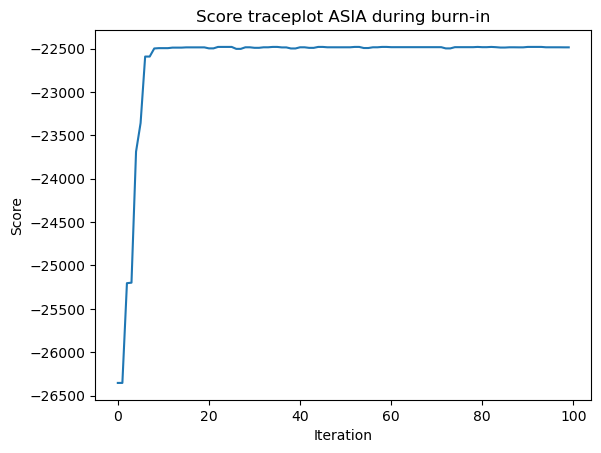

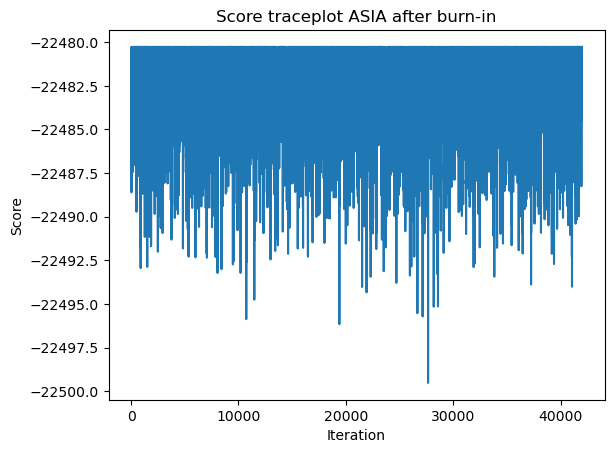

Optimal number of chains for parallel tempering:  13


In [31]:
ASIA_scores=ASIA_structure_MCMC[0]

plt.plot(ASIA_scores[:100])
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Score traceplot ASIA during burn-in')
plt.show()

plt.plot(ASIA_scores[10000:])
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Score traceplot ASIA after burn-in')
plt.show()

print ('Optimal number of chains for parallel tempering: ', ASIA_structure_MCMC[2])

In [32]:
ASIA_DAGs=ASIA_structure_MCMC[1]

print('DAGs are represented as adjacency matrices, therefore the tensor that contains all the DAGs sampled has shape: \n(n_nodes, n_nodes, n_DAGs sampled) \n')

print('In our case the shape is:', np.shape(ASIA_DAGs),'\n \n')


print('Posterior probability of the edges using matrix notation (each entry represents the posterior probability of the edge going from node i (row index) to node j (column index)) \n')

print(np.around(dag_mean_post(x=ASIA_DAGs,start=10000,end=52000),2))


DAGs are represented as adjacency matrices, therefore the tensor that contains all the DAGs sampled has shape: 
(n_nodes, n_nodes, n_DAGs sampled) 

In our case the shape is: (8, 8, 52000) 
 

Posterior probability of the edges using matrix notation (each entry represents the posterior probability of the edge going from node i (row index) to node j (column index)) 

[[0.   0.66 0.66 0.   0.01 0.08 0.   0.  ]
 [0.34 0.   0.   0.02 0.04 0.98 0.02 0.  ]
 [0.34 0.   0.   0.   0.03 0.04 0.   1.  ]
 [0.   0.02 0.01 0.   0.4  0.13 0.01 0.  ]
 [0.01 0.02 0.02 0.45 0.   0.96 0.02 0.  ]
 [0.   0.02 0.   0.02 0.04 0.   0.98 1.  ]
 [0.   0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.01 0.   0.   0.01 0.  ]]
